In [1]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# This is a function I stole from somewhere to draw a line.
# I also repurposed it for the ray casting.
def get_line(start, end):
    """Bresenham's Line Algorithm
    Produces a list of tuples from start and end
 
    >>> points1 = get_line((0, 0), (3, 4))
    >>> points2 = get_line((3, 4), (0, 0))
    >>> assert(set(points1) == set(points2))
    >>> print points1
    [(0, 0), (1, 1), (1, 2), (2, 3), (3, 4)]
    >>> print points2
    [(3, 4), (2, 3), (1, 2), (1, 1), (0, 0)]
    """  
    # Setup initial conditions
    x1, y1 = start
    x2, y2 = end
    dx = x2 - x1
    dy = y2 - y1
 
    # Determine how steep the line is
    is_steep = abs(dy) > abs(dx)
 
    # Rotate line
    if is_steep:
        x1, y1 = y1, x1
        x2, y2 = y2, x2
 
    # Swap start and end points if necessary and store swap state
    swapped = False
    if x1 > x2:
        x1, x2 = x2, x1
        y1, y2 = y2, y1
        swapped = True
 
    # Recalculate differentials
    dx = x2 - x1
    dy = y2 - y1
 
    # Calculate error
    error = int(dx / 2.0)
    ystep = 1 if y1 < y2 else -1
 
    # Iterate over bounding box generating points between start and end
    y = y1
    points = []
    for x in range(x1, x2 + 1):
        coord = (y, x) if is_steep else (x, y)
        points.append(coord)
        error -= abs(dy)
        if error < 0:
            y += ystep
            error += dx
 
    # Reverse the list if the coordinates were swapped
    if swapped:
        points.reverse()
    return points

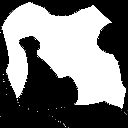

In [3]:
# loads the current test map.
# This map should probably be randomly generated, otherwise we're biasing our training a lot to this specific map layout.
img = load_img('line trace map.png')
img = img.resize((128, 128))
img

In [6]:
# Very lazy training set generation code.
# Uses a lot of memory as it just loads all the images into a big array in memory.
# Could be saved to file instead, then streamed in, there's probably an easy way to stream in files with Keras.

import random
import math
import numpy as np

images = []
hit_locations = []
headings = []
line_length = math.sqrt(img.width ** 2 + img.height ** 2)
compass_radius = 10
for _ in range(100000): # Change this to reduce the number of training examples / memory load
    placed_compass = False
    while not placed_compass:
        # Reset image
        new_image = img.copy()
        out_hit = (0, 0)
        
        # Get random line, long enough to span entire image
        start = (random.randint(0, img.width - 1), random.randint(0, img.height - 1))
        heading = 2 * math.pi * random.random()
        end = (int(line_length * math.cos(heading) + start[0]), int(line_length * math.sin(heading) + start[1]))
        
        # Try paint compass and perform line trace from end
        out_hit = start
        line_coords = get_line(start, end)
        for i, pixel_coord in enumerate(line_coords):
            
            # Retry if outside of image
            x, y = pixel_coord
            if x < 0 or x >= new_image.width or y < 0 or y >= new_image.height:
                break
                
            # Keep track of current end of line for hit results
            out_hit = pixel_coord
                
            # Retry if placed inside solid
            if new_image.getpixel(pixel_coord) != (255, 255, 255):
                break
                
            # Success if we painted all pixels without hitting a solid
            vpixel = np.array(pixel_coord)
            vstart = np.array(start)
            if np.linalg.norm(vpixel - vstart) > 2 * compass_radius:
                placed_compass = True
                continue
                
            # Select pixel color for north and south poles
            if np.linalg.norm(vpixel - vstart) < compass_radius:
                pixel_color = (127, 127, 127)
            else:
                pixel_color = (255, 0, 0)
            
            # Place new pixel on line
            new_image.putpixel(pixel_coord, pixel_color)
    
    hit_locations.append(out_hit)
    images.append(new_image)
    headings.append(heading)

# Paint hit locations
# for i, hit_loc in enumerate(hit_locations):
#     images[i].putpixel(hit_loc, (0, 255, 0))

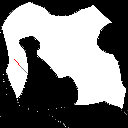

In [7]:
# Sample with compass drawn on map (compass is currently only 1 pixel wide, may be unfair representation of a game object)
images[7]

In [8]:
# Test train split (Keras also makes its own train / validation split on the training data)
TRAIN_PERCENT = 0.80

split_loc = int(len(images) * TRAIN_PERCENT)
x_train = np.array([np.array(image) for image in images[:split_loc]])
y_train = np.array([np.array(hit_loc) for hit_loc in hit_locations[:split_loc]])
x_test = np.array([np.array(image) for image in images[split_loc:]])
y_test = np.array([np.array(hit_loc) for hit_loc in hit_locations[split_loc:]])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')
y_train[:, 0] /= (x_train.shape[2] - 1)
y_train[:, 1] /= (x_train.shape[1] - 1)
y_test[:, 0] /= (x_test.shape[2] - 1)
y_test[:, 1] /= (x_test.shape[1] - 1)

In [9]:
# TRAIN_PERCENT = 0.80

# split_loc = int(len(images) * TRAIN_PERCENT)
# x_train = np.array([np.array(image) for image in images[:split_loc]])
# y_train = np.array([np.array(heading) for heading in headings[:split_loc]])
# x_test = np.array([np.array(image) for image in images[split_loc:]])
# y_test = np.array([np.array(heading) for heading in headings[split_loc:]])

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train = x_train / 255.0
# x_test = x_test / 255.0

# y_train = y_train.astype('float32')
# y_test = y_test.astype('float32')
# y_train /= 2 * math.pi
# y_test /= 2 * math.pi

(80000, 128, 128, 3)
[1. 1. 1.]


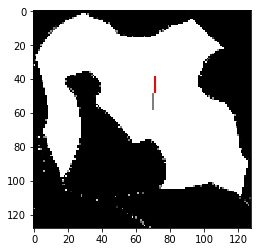

In [10]:
# larger view of a sample from the training set
print(x_train.shape)
print(x_train[0, 100, 100])
plt.imshow(x_train[1])

In [11]:
# Sample of training labels
print(y_train.shape)
print(y_train[1])

(80000, 2)
[0.56692916 0.10236221]


In [12]:
# Checking test sets shape
print(x_test.shape)
print(y_test.shape)

(20000, 128, 128, 3)
(20000, 2)


In [13]:
import keras
from coord import CoordinateChannel2D

# Function that builds the neural network model
def get_model(input_shape):
    ip = keras.layers.Input(shape=input_shape)
    x = keras.layers.Conv2D(32, (3, 3), strides=2, padding='same')(ip)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Conv2D(32, (3, 3), strides=2, padding='same')(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Flatten()(x)
    
    x = keras.layers.Dense(32)(x)
    x = keras.layers.Activation('relu')(x)
    
    x = keras.layers.Dense(2)(x)
#     x = keras.layers.Dense(1)(x)

    model = keras.models.Model(ip, x)
    return model

In [14]:
# Builds the model and sets up the optimizer for our problem.
# Prints summary of model.

keras.backend.clear_session()

model = get_model(x_train[0].shape)
model.compile(
    optimizer='adam', 
    loss='mean_squared_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
acti

In [15]:
# Runs the training for 100 epochs (complete runs over training set) or until early stopping criteria is met

from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, callbacks=[es])

Instructions for updating:
Use tf.cast instead.
Train on 53599 samples, validate on 26401 samples
Epoch 1/100
53599/53599 [==============================] - 24s 457us/step - loss: 0.0586 - val_loss: 0.0329
Epoch 2/100
53599/53599 [==============================] - 19s 363us/step - loss: 0.0383 - val_loss: 0.0156
Epoch 3/100
53599/53599 [==============================] - 20s 371us/step - loss: 0.0114 - val_loss: 0.0096
Epoch 4/100
53599/53599 [==============================] - 20s 368us/step - loss: 0.0084 - val_loss: 0.0072
Epoch 5/100
53599/53599 [==============================] - 19s 363us/step - loss: 0.0057 - val_loss: 0.0054
Epoch 6/100
53599/53599 [==============================] - 19s 362us/step - loss: 0.0050 - val_loss: 0.0047
Epoch 7/100
53599/53599 [==============================] - 20s 365us/step - loss: 0.0041 - val_loss: 0.0045
Epoch 8/100
53599/53599 [==============================] - 20s 365us/step - loss: 0.0038 - val_loss: 0.0039
Epoch 9/100
53599/53599 [=============

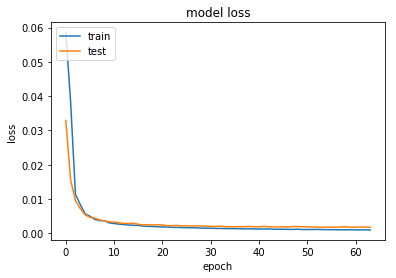

In [16]:
# summarize history for accuracy
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()

# Summarize performance
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
# Run final evaluation on our hold out test set
model.evaluate(x_test, y_test)

20000/20000 [==============================] - 4s 184us/step


0.001872245550248772

In [18]:
y_hat = model.predict(x_test)
print(y_hat)

[[0.7488961  0.74858296]
 [0.3131899  0.4391665 ]
 [0.7875297  0.22585152]
 ...
 [0.5167425  0.59854245]
 [0.8969455  0.4434789 ]
 [0.73038876 0.81507194]]


In [19]:
# import random

# rand_im_idx = random.randint(0, x_test.shape[0] - 1)
# test_img = x_test[rand_im_idx]
# print("True Value: {}".format(y_test[rand_im_idx] * 360))
# print("Prediction: {}".format(y_hat[rand_im_idx] * 360))
# print("Error: {}".format((y_hat[rand_im_idx] - y_test[rand_im_idx]) * 360))
# print("Avg Error: {}".format(np.mean(np.abs(y_test - y_hat.flatten())) * 360))
# plt.imshow(test_img)

[0.21649408 0.03628027]
(27, 5)
(25, 3)


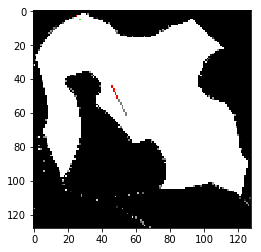

In [20]:
# Displays random result from the test set

import random

# Predicted hit point (shown in green)
rand_im_idx = random.randint(0, x_test.shape[0] - 1)
test_img = x_test[rand_im_idx]
print(y_hat[rand_im_idx])
hit_x = y_hat[rand_im_idx][0]
hit_x *= test_img.shape[1] - 1 # [0.0..1.0] x Image width
hit_x = int(round(hit_x))
hit_y = y_hat[rand_im_idx][1]
hit_y *= test_img.shape[0] - 1 # [0.0..1.0] x Image height
hit_y = int(round(hit_y))
print((hit_x, hit_y))

# Target hit point (shown in red)
t_hit_x = y_test[rand_im_idx][0]
t_hit_x *= test_img.shape[1] - 1 # [0.0..1.0] x Image width
t_hit_x = int(round(t_hit_x))
t_hit_y = y_test[rand_im_idx][1]
t_hit_y *= test_img.shape[0] - 1 # [0.0..1.0] x Image height
t_hit_y = int(round(t_hit_y))
print((t_hit_x, t_hit_y))

test_img[hit_y, hit_x] = (0., 1., 0)
test_img[t_hit_y, t_hit_x] = (1., 0., 0.)
plt.imshow(test_img)